# Modeling Workflow

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import lmfit
import util

## Review of Model Fitting

In [2]:
import lmfit
import numpy

def calculate(x, amp, phase, freq, decay):
    """
    :param Parameters params:
    :param array x: independent variable(s)
    :param array data: observed values to fit to
    """
    return amp*np.sin(x*freq + phase)*np.exp(-x*x*decay)
    
# Synthetic data
x = np.linspace(0, 10, 100)
AMP = 3.0
FREQ = 1.0
PHASE = 0.0
DECAY = 0.1
data = calculate(x, AMP, PHASE, FREQ, DECAY)


# Fitting
params = lmfit.Parameters()
params.add('amp', value=10)
params.add('freq', value=3)
params.add('phase', value=.2)
params.add('decay', value = 1.0)
#
model = lmfit.Model(calculate)
fitter = model.fit(data, params, x=x) 
fitter.params


Parameters([('amp',
             <Parameter 'amp', value=3.00000000084041 +/- 1.26e-10, bounds=[-inf:inf]>),
            ('freq',
             <Parameter 'freq', value=1.0000000002562435 +/- 2.1e-11, bounds=[-inf:inf]>),
            ('phase',
             <Parameter 'phase', value=-2.732487809161068e-10 +/- 4.37e-11, bounds=[-inf:inf]>),
            ('decay',
             <Parameter 'decay', value=0.10000000004427274 +/- 1.02e-11, bounds=[-inf:inf]>)])

In [3]:
print(fitter.fit_report())

[[Model]]
    Model(calculate)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 100
    # variables        = 4
    chi-square         = 8.5714e-18
    reduced chi-square = 8.9285e-20
    Akaike info crit   = -4382.32720
    Bayesian info crit = -4371.90652
[[Variables]]
    amp:    3.00000000 +/- 1.2630e-10 (0.00%) (init = 10)
    freq:   1.00000000 +/- 2.0970e-11 (0.00%) (init = 3)
    phase: -2.7325e-10 +/- 4.3739e-11 (16.01%) (init = 0.2)
    decay:  0.10000000 +/- 1.0233e-11 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decay)  =  0.652
    C(freq, decay) = -0.141
    C(amp, freq)   = -0.108



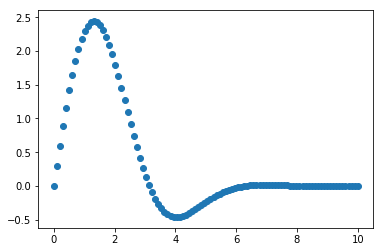

In [4]:
plt.scatter(x, data)

In [5]:
print(fitter.fit_report())

[[Model]]
    Model(calculate)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 100
    # variables        = 4
    chi-square         = 8.5714e-18
    reduced chi-square = 8.9285e-20
    Akaike info crit   = -4382.32720
    Bayesian info crit = -4371.90652
[[Variables]]
    amp:    3.00000000 +/- 1.2630e-10 (0.00%) (init = 10)
    freq:   1.00000000 +/- 2.0970e-11 (0.00%) (init = 3)
    phase: -2.7325e-10 +/- 4.3739e-11 (16.01%) (init = 0.2)
    decay:  0.10000000 +/- 1.0233e-11 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decay)  =  0.652
    C(freq, decay) = -0.141
    C(amp, freq)   = -0.108



In [6]:
fitter.params.get('amp').value

3.00000000084041

In [7]:
for name in fitter.params:
    print (name)

amp
freq
phase
decay


In [8]:
for name in fitter.params:
    param = fitter.params.get(name)
    stmt = "%s = %3.4f" % (name, param.value)
    exec(stmt)
fit = calculate(x, amp, freq, phase, decay)

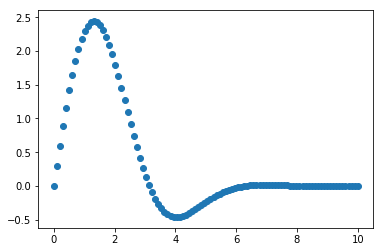

In [9]:

plt.scatter(x, model.eval(fitter.params, x=x))

Text(0,0.5,'Fitted')

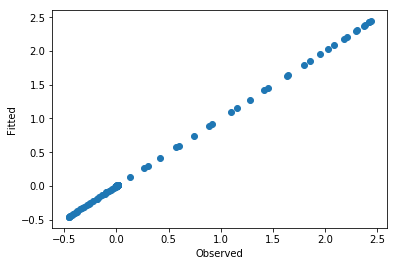

In [10]:
# Plot the result
plt.scatter(data,  model.eval(fitter.params, x=x))
plt.xlabel("Observed")
plt.ylabel("Fitted")

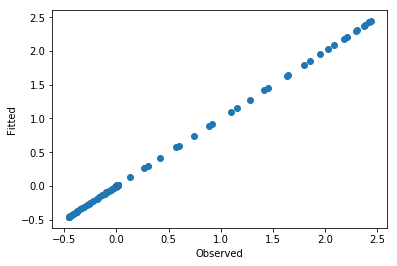

In [11]:
# We will do this a lot. A better way is to make a function that does the plot.
util.plotFit(data, model.eval(fitter.params, x=x))

## Fitting a Simulation to One Species Concentration
1. Make simulation into a function
1. Create observations
1. Create parameters
1. Fit the model
1. Generate fitted simulation data
1. Compare the fit with the data

In [12]:
# Encapsulate the simulation into a function

# Use constants, not numbers, so that values can be changed easily and promote readability.
START = 0
STOP = 50
NUM_POINTS = 100
def simulateModel(v0, ka, kb, kc):
    """
    Simulate the model for specific parameter values.
    :param array x: dummy independent variable
    :return array-float: [B]
    """
    model = """
    model test
        species A, B, C;

        J0: -> A; v0
        A -> B; ka*A;
        B -> C; kb*B;
        J1: C ->; C*kc
        A = 0
        B = 0
        C = 0
        v0 = 10
        ka = 0.4
        kb = 0.8*ka
        kc = ka

    end
    """
    r = te.loada(model)
    r.v0 = v0
    r.ka = ka
    r.kb = kb
    r.kc =kc
    return r.simulate(START, STOP, NUM_POINTS)
    
def simulate(v0=10, ka=0.4, kb=0.32, kc=0.4):
    results = simulateModel(v0, ka, kb, kc)
    return results["[B]"]

In [13]:
# Generate synthetic observations
STD = 1.0
data = simulate() + np.random.normal(0, STD, NUM_POINTS)

In [14]:
# Create the parameters of simulation
params = lmfit.Parameters()
params.add('v0', value=100, min=0)
params.add('ka', value=.1, min=0)
params.add('kb', value=.1, min=0)
params.add('kc', value = 0.1, min=0)

In [15]:
# Do the fit
model = lmfit.Model(simulate, independent_vars=[], method='leastsq')  # Specifying no independent variables
fitter = model.fit(data, params) 
fitter.params

Parameters([('v0',
             <Parameter 'v0', value=435.10932115787335 +/- 1.18e+06, bounds=[0:inf]>),
            ('ka',
             <Parameter 'ka', value=177.52737404654434 +/- 3.23e+07, bounds=[0:inf]>),
            ('kb',
             <Parameter 'kb', value=15.601870169243188 +/- 4.22e+04, bounds=[0:inf]>),
            ('kc',
             <Parameter 'kc', value=5136097.147854442 +/- 1.21e+11, bounds=[0:inf]>)])

In [16]:
print( fitter.fit_report())

[[Model]]
    Model(simulate)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 100
    # variables        = 4
    chi-square         = 5156.10994
    reduced chi-square = 53.7094785
    Akaike info crit   = 402.276750
    Bayesian info crit = 412.697431
[[Variables]]
    v0:  435.109321 +/- 1176649.93 (270426.28%) (init = 100)
    ka:  177.527374 +/- 32344734.1 (18219575.57%) (init = 0.1)
    kb:  15.6018702 +/- 42191.4844 (270425.81%) (init = 0.1)
    kc:  5136097.15 +/- 1.2052e+11 (2346531.34%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(v0, kb) =  1.000
    C(ka, kb) = -0.998
    C(v0, ka) = -0.998
    C(ka, kc) =  0.954
    C(kb, kc) = -0.934
    C(v0, kc) = -0.934



In [17]:
# Run the simulation to get fitted values
fit = fitter.eval(fitter.params)

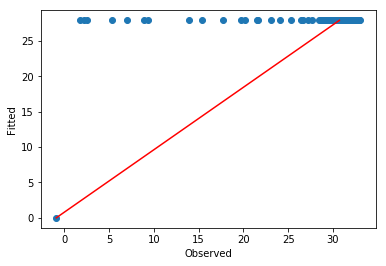

In [18]:
util.plotFit(data, fit)

## Fit With Cross Validation
These fits will be to all concentrations

In [19]:
def convertResultsToArray(results):
    """
    Concatentates the non-time columns of a simulation result
    by alternating columns for rows.
    :param NamedArray results
    """
    num_cols = results.shape[1]
    results = results[:, 1:]
    new_length = len(results)*(num_cols - 1)
    array = results.reshape(new_length)
    return array

In [20]:
# Generate synthetic observations
STD = 1.0
def generateObservations(std=STD):
    """
    :return NamedArray: simulation results with normal errors
    """
    v0=10; ka=0.4; kb=0.32; kc=0.4;
    results = simulateModel(v0, ka, kb, kc)
    columns = results.colnames
    for col in range(1, len(results.colnames)):
        for row in range(len(results)):
            results[row, col] = max(results[row, col] + np.random.normal(0, std), 0)
    results.colnames = columns
    return results

In [21]:
# Uses the independent variable to pass the indices to report
def simulateWithIndices(x, v0, ka, kb, kc):
    """
    :param array-int x: indices to return
    """
    results = simulateModel(v0, ka, kb, kc)
    indices = [int(v) for v in x]
    results = results[indices]
    return convertResultsToArray(results)

In [22]:
# Create the parameters of simulation
params = lmfit.Parameters()
params.add('v0', value=100, min=0)
params.add('ka', value=2, min=0)
params.add('kb', value=.5, min=0)
params.add('kc', value = 0.1, min=0)

In [23]:
# Create the fold generator
NUM_FOLDS = 4
data = generateObservations(std=4.0)
generator = util.foldGenerator(NUM_POINTS, NUM_FOLDS)
eval_statistics = []  # Acccumulates statistics
parameters_collection = []
# Fit training data and evaluate on test data for each fold
for train, test in generator:
    # Do the fit
    model = lmfit.Model(simulateWithIndices, method='leastsq')  # Specifying no independent variables
    data_train = convertResultsToArray(data[train])
    fitter = model.fit(data_train, params, x=train) 
    fit = model.eval(fitter.params, x=test)
    data_test = convertResultsToArray(data[test])
    eval_statistics.append(r2_score(data_test, fit))
    parameters_collection.append(fitter.params)
# Report the results
print("Mean R2: %2.3f,  Std R2: %2.3f" % (np.mean(eval_statistics), np.std(eval_statistics)))

Mean R2: 0.715,  Std R2: 0.030


In [24]:
# Compute average values of parameters and show fit
fitted_parameters = util.aggregateParameters(parameters_collection)

In [25]:
fitted_parameters

Parameters([('ka', <Parameter 'ka', 0.4395254196302988, bounds=[-inf:inf]>),
            ('kc', <Parameter 'kc', 0.4305789667187228, bounds=[-inf:inf]>),
            ('kb', <Parameter 'kb', 0.3584965945119631, bounds=[-inf:inf]>),
            ('v0', <Parameter 'v0', 10.825825736850717, bounds=[-inf:inf]>)])

## Bootstrapping
We must do the following:
1. Use the fitted_parameters obtained from the averages across cross validations as the initial parameters to fit to all of the data.
1. Construct collection-of-parameters
  1. Compute synthetic data by using random draws of residuals
  1. Estimate the parameters and add to collection-of-parameters
1. Report the mean and std of the collection-of-parameters

In [26]:
# Compute a fit with the parameters averaged across all folds
# Notes. Using the same data as for cross validation
INDICES = range(len(data))
data_as_array = convertResultsToArray(data)
model = lmfit.Model(simulateWithIndices, method='leastsq')  # Specifying no independent variables
fitter = model.fit(data_as_array, fitted_parameters, x=INDICES) 
full_fit = model.eval(fitter.params, x=INDICES)

In [27]:
print(fitter.fit_report())

[[Model]]
    Model(simulateWithIndices)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 300
    # variables        = 4
    chi-square         = 4750.99044
    reduced chi-square = 16.0506434
    Akaike info crit   = 836.697774
    Bayesian info crit = 851.512904
[[Variables]]
    ka:  0.43941177 +/- 0.01672405 (3.81%) (init = 0.4395254)
    kc:  0.43044619 +/- 0.01932406 (4.49%) (init = 0.430579)
    kb:  0.35829537 +/- 0.01410314 (3.94%) (init = 0.3584966)
    v0:  10.8227332 +/- 0.37567581 (3.47%) (init = 10.82583)
[[Correlations]] (unreported correlations are < 0.100)
    C(kb, v0) =  0.926
    C(kc, v0) =  0.912
    C(ka, v0) =  0.891
    C(kc, kb) =  0.849
    C(ka, kb) =  0.829
    C(ka, kc) =  0.818



In [34]:
# Construct the collection of parameters
NUM_BOOTSTRAPPING_ITERATIONS = 10
parameters_collection = []
for _ in range(NUM_BOOTSTRAPPING_ITERATIONS):
    new_data_as_array = util.generateBootstrapData(full_fit, data_as_array)
    model = lmfit.Model(simulateWithIndices, method='leastsq')  # Specifying no independent variables
    fitter = model.fit(new_data_as_array, fitted_parameters, x=INDICES)
    parameters_collection.append(fitter.params)

In [35]:
# Calculate statistics for the parameters
print("Name\tMean\tStd")
for name, values in util.makeParametersStatistics(parameters_collection).items():
    print("%s\t%3.3f\t%3.3f" % (name, values[0], values[1]))

Name	Mean	Std
ka	0.435	0.019
kb	0.358	0.012
kc	0.425	0.019
v0	10.732	0.381
